In [1]:
from __future__ import division

import datautils
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import math
import models

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
# Read in the data
num_classes = 250 #250
res = 128

tic = time.clock()
X_train, y_train, X_val, y_val, X_test, y_test, labels = datautils.get_data(num_classes=num_classes, res=128, flip=True)
toc = time.clock()
print ("Read {} images in {:5g} seconds".format(X_train.shape[0] + X_val.shape[0] + X_test.shape[0], toc - tic))


Read 32000 images in 6.63903 seconds


In [3]:
print ("X_train: ", X_train.shape)
print ("y_train: ", y_train.shape)
print ("X_val: ", X_val.shape)
print ("y_val: ", y_val.shape)
print ("X_test: ", X_test.shape)
print ("y_test: ", y_test.shape)

X_train:  (24000, 128, 128, 1)
y_train:  (24000,)
X_val:  (4000, 128, 128, 1)
y_val:  (4000,)
X_test:  (4000, 128, 128, 1)
y_test:  (4000,)


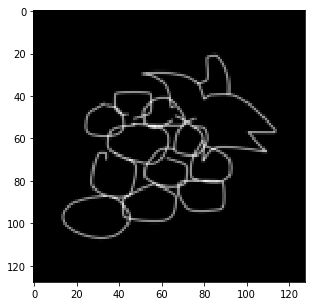

grapes


In [4]:
# Plot a random image
sample = np.random.randint(X_train.shape[0])
plt.imshow(X_train[sample].reshape(128, 128))
plt.show()
print (labels[y_train[sample]])

In [5]:
tf.reset_default_graph()

reg_val = 1e0
learning_rate = 1e-3
dr = 0.6

X = tf.placeholder(tf.float32, [None, res, res, 1])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)
lr = tf.placeholder(tf.float32)
reg = tf.placeholder(tf.float32)
dropout_rate = tf.placeholder(tf.float32)

y_out = models.resnet_wide(X, y, 
                           layer_depth=3, 
                           num_classes=num_classes, 
                           is_training=is_training, 
                           reg=reg,
                           dropout=dropout_rate)
print (y_out.shape)
mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y, num_classes), logits=y_out))
optimizer = tf.train.AdamOptimizer(learning_rate=lr)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

(?, 250)


In [6]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
                # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
                        # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:], 
                         y: yd[idx], 
                         is_training:training_now,
                         lr : learning_rate, 
                         reg: reg_val,
                         dropout_rate: dr}
                        
                        
            # get batch size
            actual_batch_size = yd[i:i+batch_size].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                                                              .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
                              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

In [7]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
train_losses = []
train_acc = []
val_losses = []
val_acc = []
saver = tf.train.Saver()
model_name = "resnet-wide-v2"

In [8]:
with open("./checkpoints/{}.txt".format(model_name)) as logs:
    train_losses = [ float(val) for val in logs.readline().split()[:20] ]
    val_losses = [ float(val) for val in logs.readline().split()[:20] ]
    train_acc = [ float(val) for val in logs.readline().split()[:20] ]
    val_acc = [ float(val) for val in logs.readline().split()[:20] ]

print(val_acc)
best_epoch = np.argmax(val_acc) + 1
print("Best epoch: {}, {}".format(best_epoch, val_acc[best_epoch - 1]))

saver.restore(sess, "./checkpoints/{}-{}".format(model_name, best_epoch))
print("Restoring {}-{}".format(model_name, best_epoch))

test_loss, test_acc = run_model(session=sess,
                                 predict=y_out,
                                 loss_val=mean_loss,
                                 Xd=X_test,
                                 yd=y_test,
                                 epochs=1,
                                 batch_size=64,
                                 print_every=10000,
                                 training=None,
                                 plot_losses=False)
print("Test accuracy: {}, loss: {}".format(test_acc, test_loss))

[0.00975, 0.0505, 0.17075, 0.0845, 0.2825, 0.29925, 0.42, 0.43025, 0.4975, 0.45275, 0.5525, 0.57675, 0.499, 0.57325, 0.59, 0.6305, 0.63175, 0.63325, 0.64, 0.6395]
Best epoch: 19, 0.64
Restoring resnet-wide-v2-19
Epoch 1, Overall loss = 1.57 and accuracy of 0.649
Test accuracy: 0.64925, loss: 1.5676349296569825


In [17]:
with open("./checkpoints/{}.txt".format(model_name)) as logs:
    train_losses = [ float(val) for val in logs.readline().split()[:15] ]
    val_losses = [ float(val) for val in logs.readline().split()[:15] ]
    train_acc = [ float(val) for val in logs.readline().split()[:15] ]
    val_acc = [ float(val) for val in logs.readline().split()[:15] ]

saver.restore(sess, "./checkpoints/{}-{}".format(model_name, len(val_acc)))
print("Restoring {}-{}".format(model_name, len(val_acc)))

Restoring resnet-wide-v2-15


In [18]:
epochs = 5
reg_val = 1e0
learning_rate = 1e-3
for i in range(epochs):
    loss, acc = run_model(session=sess,
                                 predict=y_out,
                                 loss_val=mean_loss,
                                 Xd=X_train,
                                 yd=y_train,
                                 epochs=1,
                                 batch_size=64,
                                 print_every=50,
                                 training=train_step,
                                 plot_losses=False)
    train_losses.append(loss)
    train_acc.append(acc)
    loss, acc = run_model(session=sess,
                                 predict=y_out,
                                 loss_val=mean_loss,
                                 Xd=X_val,
                                 yd=y_val,
                                 epochs=1,
                                 batch_size=64,
                                 print_every=10000,
                                 training=None,
                                 plot_losses=False)
    val_losses.append(loss)
    val_acc.append(acc)
    saver.save(sess, "./checkpoints/" + model_name, global_step=len(val_acc))
    f = open("./checkpoints/" + model_name + ".txt", 'w')
    f.write(" ".join([str(num) for num in train_losses]) + "\n")
    f.write(" ".join([str(num) for num in val_losses]) + "\n")
    f.write(" ".join([str(num) for num in train_acc]) + "\n")
    f.write(" ".join([str(num) for num in val_acc]) + "\n")
    f.close()

Iteration 0: with minibatch training loss = 0.629 and accuracy of 0.81
Iteration 50: with minibatch training loss = 0.759 and accuracy of 0.75
Iteration 100: with minibatch training loss = 0.308 and accuracy of 0.94
Iteration 150: with minibatch training loss = 0.414 and accuracy of 0.86
Iteration 200: with minibatch training loss = 0.583 and accuracy of 0.83
Iteration 250: with minibatch training loss = 0.468 and accuracy of 0.89
Iteration 300: with minibatch training loss = 0.407 and accuracy of 0.88
Iteration 350: with minibatch training loss = 0.321 and accuracy of 0.91
Epoch 1, Overall loss = 0.482 and accuracy of 0.862
Epoch 1, Overall loss = 1.58 and accuracy of 0.63
Iteration 0: with minibatch training loss = 0.422 and accuracy of 0.89
Iteration 50: with minibatch training loss = 0.432 and accuracy of 0.89
Iteration 100: with minibatch training loss = 0.388 and accuracy of 0.86
Iteration 150: with minibatch training loss = 0.462 and accuracy of 0.86
Iteration 200: with minibatc

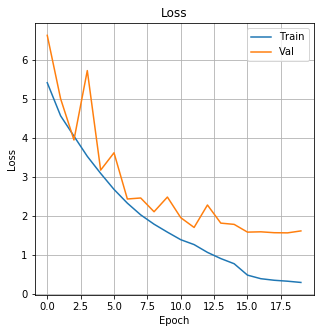

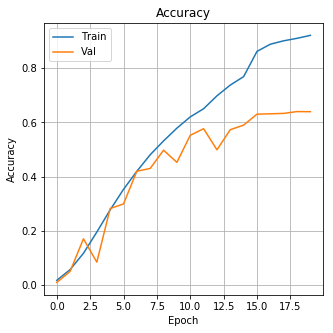

In [19]:
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.grid(True)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Val')
plt.grid(True)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
run_model(session=sess,
            predict=y_out,
            loss_val=mean_loss,
            Xd=X_test,
            yd=y_test,
            epochs=1,
            batch_size=64,
            print_every=10000,
            training=None,
            plot_losses=False)

Epoch 1, Overall loss = 1.61 and accuracy of 0.643


(1.6073822469711303, 0.64300000000000002)